# COSI123A Final Project
### Group Name: NKG
### Group Members: Nicole Meng, Kevin Dai, Grant Gu

In [23]:
import numpy as np
import pandas as pd
import csv
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Import and Split Data

In [24]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
train_updates = pd.read_csv("train_updates_20220929.csv")

#suppress that warning
pd.set_option('mode.chained_assignment', None)

#converting the types
test["seq_id"][0:] = test["seq_id"][0:].astype(float).astype(int)
train["seq_id"][0:] = train["seq_id"][0:].astype(float).astype(int)
train["pH"][0:] = train["pH"][0:].astype(float)
train["tm"][0:] = train["tm"][0:].astype(float)
train_updates["seq_id"][0:]= train_updates["seq_id"][0:].astype(float).astype(int)
train_updates["pH"][0:] = train_updates["pH"][0:].astype(float)
train_updates["tm"][0:] = train_updates["tm"][0:].astype(float)

#reenable the warning just in case
pd.set_option('mode.chained_assignment', 'warn')

In [25]:
#update train to contain the correct training data
for i in range(0, 2434):
    fix_id = train_updates["seq_id"][i] #the id that needs to be fixed
    train.iloc[fix_id] = train_updates.iloc[i]

#change protein_sequences back to str
train["protein_sequence"] = train["protein_sequence"].astype(str)

In [26]:
#for debugging
#for seq in train["protein_sequence"]:
#    if len(seq) < 20:
#        print(seq)

In [27]:
#drop irrelevant column - data source
train = train.drop(columns = ['data_source'])

#drop invalid pH values (not sure we need this anymore?)
for i in range(0, 31390):
    ph = train["pH"][i] #the ph value
    if ph < 0 or ph > 14:
        train.drop(i)
        
#drop NaNs
for i in range(0,len(train["pH"])):
    if train["protein_sequence"][i] == "nan":
        train = train.drop([i])
        i = i-1

# Data Preprocessing
Drop the columns that is wrong or does not provide useful inforamtion

Drop rows that has Nan in sequence column. 
Add a wild type column 
Add a group column to store the group this sample is assigned to

In [28]:
#drop nan rows
train=train[train["protein_sequence"].notna()]
print(train)
wild_col=[' ']*28981 #add a wild type column
train.insert(loc=1,column='wild',value=wild_col)
group_col=[0]*28981
train.insert(loc=1,column='group',value=group_col)
train.insert(loc=1,column='seq_len',value=train["protein_sequence"].str.len())

print(train)
#drop sequences of length appear less than 20 times
indexes=train.seq_len.value_counts().loc[lambda x: x>20].reset_index()['index']
#print(indexes)
for index in indexes:
    train.drop(train[train['seq_len']==index].index, inplace=True)
print(train)


       seq_id                                   protein_sequence   pH    tm
0           0  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0  75.7
1           1  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0  50.5
2           2  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0  40.5
3           3  AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0  47.2
4           4  AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0  49.5
...       ...                                                ...  ...   ...
31385   31385  YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...  7.0  51.8
31386   31386  YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...  7.0  37.2
31387   31387  YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...  7.0  64.6
31388   31388  YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...  7.0  50.7
31389   31389  YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...  7.0  37.6

[28981 rows x 4 columns]
       seq_id  seq_len  group wild  \
0           0      341  

Compare sequences to see if they differ by less than 2 mutation

In [29]:
def compare_seq(seq1,seq2):
    if(type(seq1)!=str):
        return 0
    if(type(seq2)!=str):
        return 0
    if(len(seq1)>len(seq2)+3 or len(seq1)<len(seq2)-3):
        return 0
    #print('seq1 len',len(seq1))
    count=0
    minlen=min(len(seq1),len(seq2))
    for i in range(minlen):
        if seq1[i]!=seq2[i]:
            count=count+1
    if count>3:
        return 0
    #print(count)
    return 1

In [30]:
def is_subseq(seq1, seq2):
    it = iter(seq2)
    return all(any(c1 == c2 for c1 in it) for c2 in seq1)

In [31]:
#We are planning on performing cross validation on the dataset with a 80-20 train-test split
X_train=train.sample(frac=0.8,random_state=200)
X_test=train.drop(X_train.index)

#Next, we will read into the dataframes we created and define some more terms
X_train_x = X_train.iloc[: , 0:-1] #80% trainng data used for training model
X_train_y = X_train.iloc[: , -1] #80% target column

X_test_x = X_test.iloc[: , 0:-1] #20% training data used for training model
X_test_y = X_test.iloc[: , -1] #20% training data used for training model

#Note: for our model training, we will only use X_train_x and X_train_y

In [32]:
seq_col=train.loc[:,"protein_sequence"]
print(seq_col)
wild_col=train.loc[:,'wild']
print(wild_col)

2        AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...
4        AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...
12       AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...
13       AAKGDCGGSGCGKCDCHGVKGQKGERGLPGLQGVIGFPGMQGPEGP...
14       AAKSGDAEEARKKLQDAAEELSKAHHYQTELIQNEAGGEKTEMTLL...
                               ...                        
31368    YVAEQFGWTVYIVMAGFAFSCLLTLPPWPIYRRHPLKWLPVQDLGT...
31377    YWDPYGTVDQLPVVVVNQDKGATYEGEKLQIGDDLVKELKDNNNFD...
31381    YYLAAVKSMTQSFHNFFYASFDPSGFVTVDKPPVVLWIQTIFALIF...
31382    YYLKHQFYPTVVYLTKSSPSMAVLYIQAFVLVFLLGKVMGKVFFGQ...
31384    YYLYGWNRGLEPSADASESDCGDPPPVAPSRLLPIKPVQAVAPSRT...
Name: protein_sequence, Length: 6794, dtype: object
2         
4         
12        
13        
14        
        ..
31368     
31377     
31381     
31382     
31384     
Name: wild, Length: 6794, dtype: object


In [33]:
group_num=1

#print(X_train_x['group'].loc[3])
for i in wild_col.index:
    current_wild=seq_col[i]
    if wild_col[i]==' ':
        print('find group for ',group_num)
        for j in wild_col.index:
            if (train.at[j,'group']==0) and (compare_seq(current_wild,seq_col[j])==1 or is_subseq(current_wild,seq_col[j])):#found relative
                train.at[j,'wild']=current_wild
                train.at[j,'group']=group_num
        group_num=group_num+1
print(train)

find group for  1
find group for  2
find group for  3
find group for  4
find group for  5
find group for  6
find group for  7
find group for  8
find group for  9
find group for  10
find group for  11
find group for  12
find group for  13
find group for  14
find group for  15
find group for  16
find group for  17
find group for  18
find group for  19
find group for  20
find group for  21
find group for  22
find group for  23
find group for  24
find group for  25
find group for  26
find group for  27
find group for  28
find group for  29
find group for  30
find group for  31
find group for  32
find group for  33
find group for  34
find group for  35
find group for  36
find group for  37
find group for  38
find group for  39
find group for  40
find group for  41
find group for  42
find group for  43
find group for  44
find group for  45
find group for  46
find group for  47
find group for  48
find group for  49
find group for  50
find group for  51
find group for  52
find group for  53
fi

In [34]:
#We are planning on performing cross validation on the dataset with a 80-20 train-test split
X_train=train.sample(frac=0.8,random_state=200)
X_test=train.drop(X_train.index)

#Next, we will read into the dataframes we created and define some more terms
X_train_x = X_train.iloc[: , 0:-1] #80% trainng data used for training model
X_train_y = X_train.iloc[: , -1] #80% target column

X_test_x = X_test.iloc[: , 0:-1] #20% training data used for training model
X_test_y = X_test.iloc[: , -1] #20% training data used for training model

#Note: for our model training, we will only use X_train_x and X_train_y

In [35]:
X_test_x

,seq_id,seq_len,group,wild,protein_sequence,pH
12,12,55,3,AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...,AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...,7.0
94,94,679,14,ADSNISVKLLNYIGNKSSISLSPTGFYKVTGDNVAVTDRFAGASRY...,ADSNISVKLLNYIGNKSSISLSPTGFYKVTGDNVAVTDRFAGASRY...,7.0
95,95,621,15,ADSQAVVCEGTACYTAHWGKLSAAEAQHRCNENGGNLATVKSEEEA...,ADSQAVVCEGTACYTAHWGKLSAAEAQHRCNENGGNLATVKSEEEA...,7.0
198,198,544,26,AGDTLREFKNATKGLTSDEEEKKKED,AGHPSSPPMVDTVQGKVLGKYISLEGFTQPVAVFLGVPFAKPPLGS...,7.0
255,255,92,30,AISCGAVTGSLGQCYNYLTRGGFIPRGCCSGVQRLNSLARTTRDRQ...,AISCGAVTGSLGQCYNYLTRGGFIPRGCCSGVQRLNSLARTTRDRQ...,7.0
...,...,...,...,...,...,...
31298,31298,38,548,YKFGVAEPRKKAYAEFYRNYDSMKDFEEMRKAGIFQSA,YKFGVAEPRKKAYAEFYRNYDSMKDFEEMRKAGIFQSA,7.0
31325,31325,811,26,AGDTLREFKNATKGLTSDEEEKKKED,YNCVSQLGELGLVEFRDLNESVSAFQRRFVVDVRRCEELEKTFTFL...,7.0
31329,31329,1137,3,AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...,YNLDTRPTQSFLAQAGRHFGYQVLQIEDGVVVGAPGEGDNTGGLYH...,7.0
31350,31350,1828,3,AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...,YRLNVPRVLLPYHPTVPVSFVLEVTHPTGGCFTWRSTRPDIVSVKR...,7.0


create sequence and wild type columns

In [36]:
# seq_col=X_train_x.loc[:,"protein_sequence"]
# print(seq_col)
# wild_col=X_train_x.loc[:,'wild']
# print(wild_col)

Data split into train and test

Data visualization

sort dataframe base on sequence, set wildtype to temp cell and adjust later

In [37]:
# group_num=1

# #print(X_train_x['group'].loc[3])
# for i in wild_col.index:
#     current_wild=seq_col[i]
#     if wild_col[i]==' ':
#         print('find group for ',group_num)
#         for j in wild_col.index:
#             if (X_train_x.at[j,'group']==0) and (compare_seq(current_wild,seq_col[j])==1 or is_subseq(current_wild,seq_col[j])):#found relative
#                 X_train_x.at[j,'wild']=current_wild
#                 X_train_x.at[j,'group']=group_num
#         group_num=group_num+1
# print(X_train_x)

function used groupby to group the similar sequences(less than 2 mutations apart)

Visualizing the data

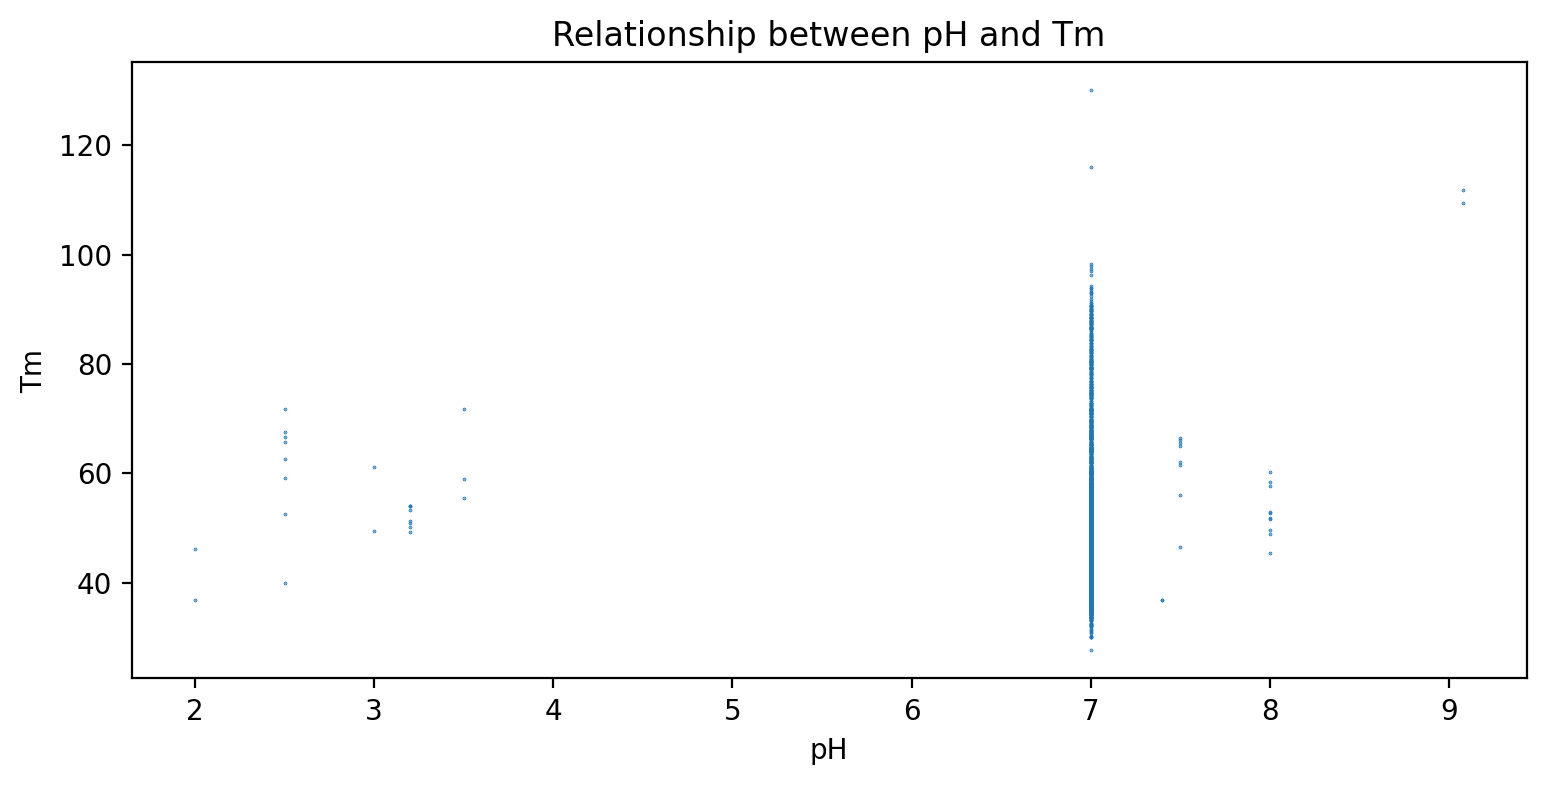

In [38]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(np.clip(train["pH"],0,14), train["tm"], s=0.1)
plt.title("Relationship between pH and Tm")
plt.xlabel("pH")
plt.ylabel("Tm")
plt.show()

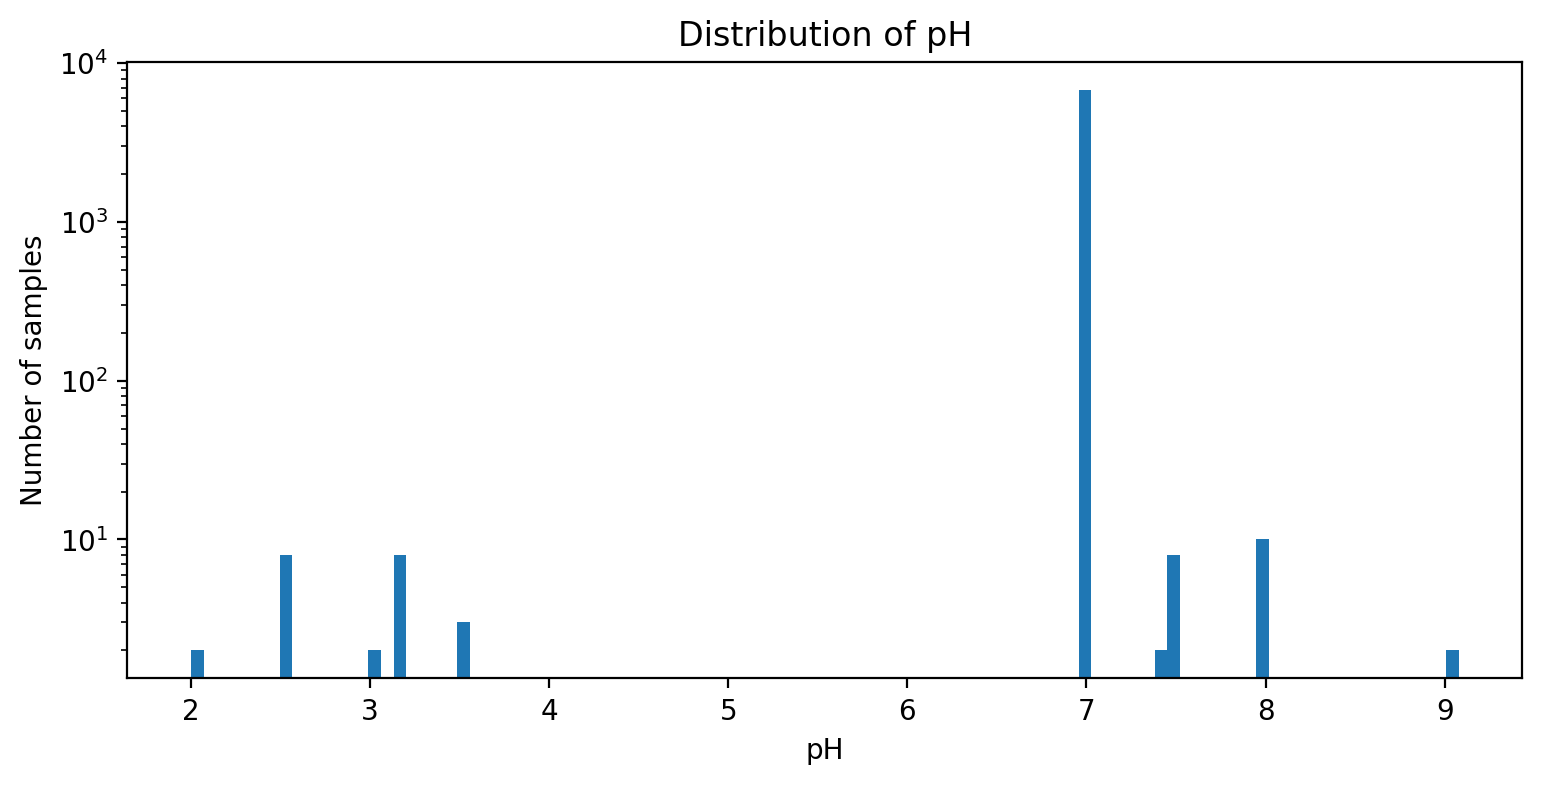

In [39]:
plt.figure(figsize=(9,4), dpi= 200)
plt.hist(np.clip(train["pH"],0,14), bins=100)
plt.title("Distribution of pH")
plt.xlabel("pH")
plt.ylabel("Number of samples")
plt.yscale('log')
plt.show()

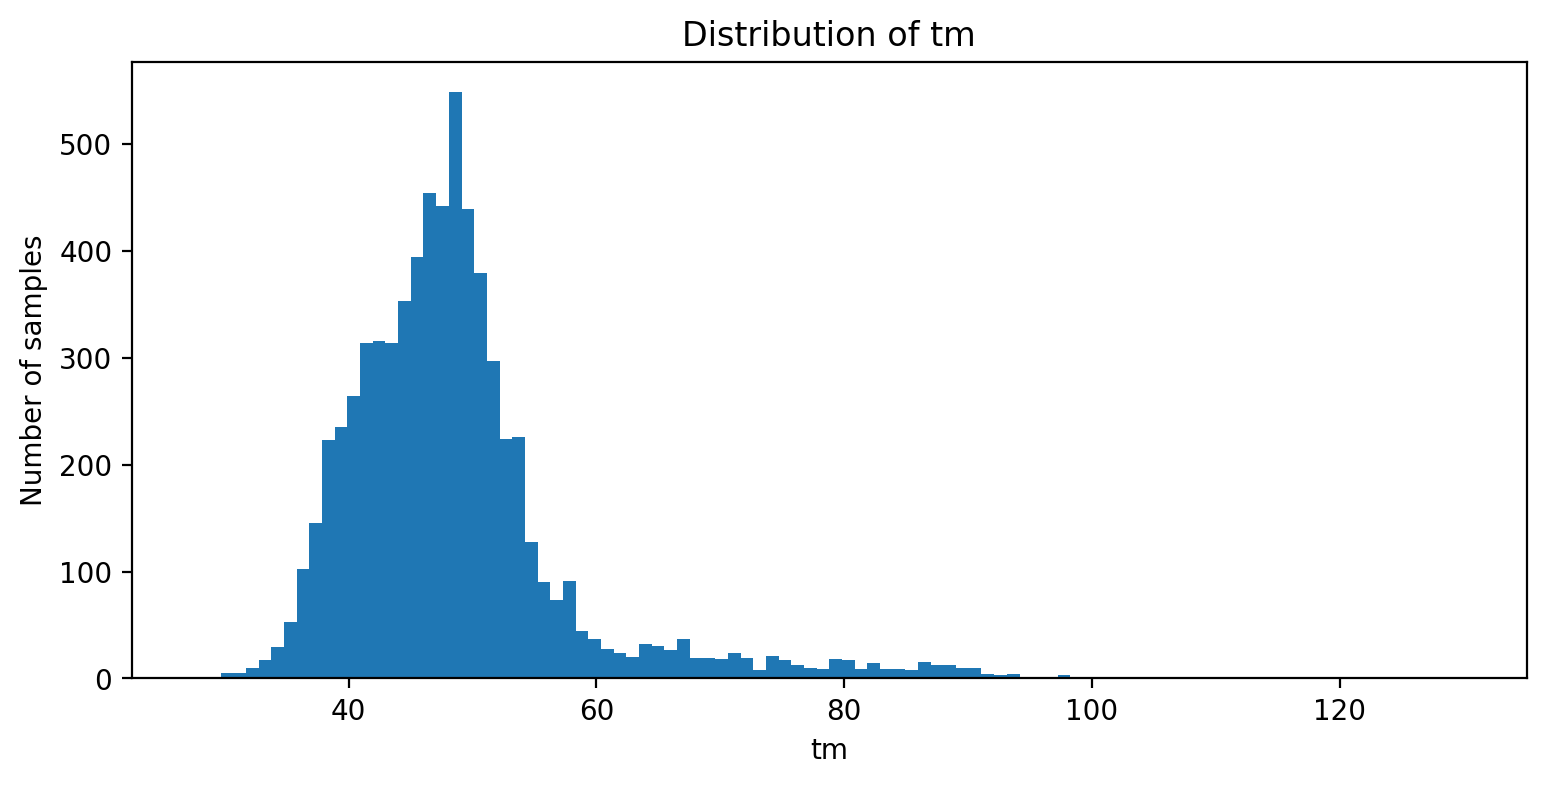

In [40]:
plt.figure(figsize=(9,4), dpi= 200)
plt.hist(train["tm"], bins=100)
plt.title("Distribution of tm")
plt.xlabel("tm")
plt.ylabel("Number of samples")
plt.show()

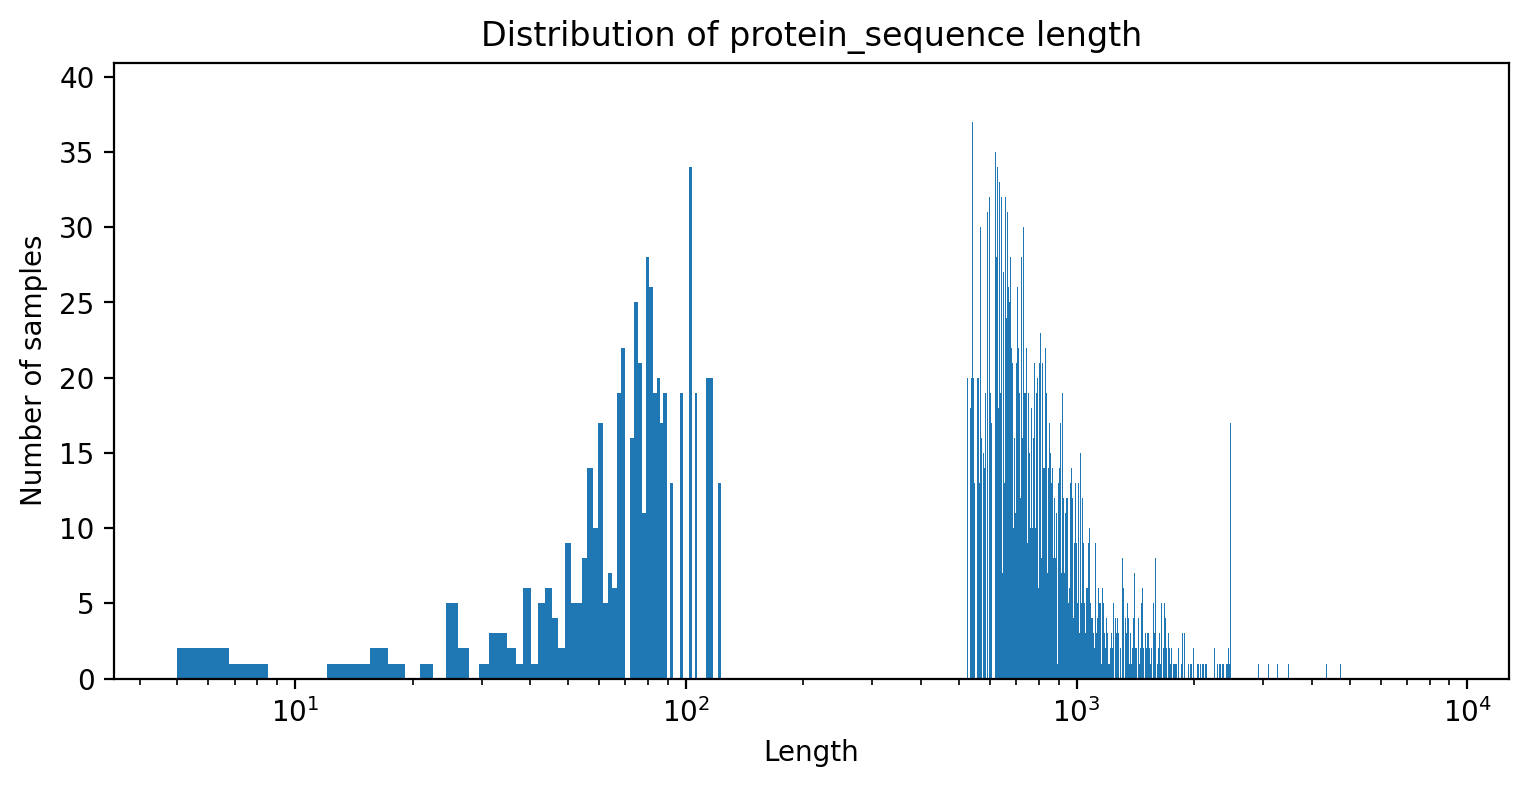

In [41]:
plt.figure(figsize=(9,4), dpi=200)
plt.hist(train["protein_sequence"].apply(lambda x:len(x)), 5000)
plt.title("Distribution of protein_sequence length")
plt.xlabel("Length")
plt.xscale('log')
plt.ylabel("Number of samples")
plt.show()

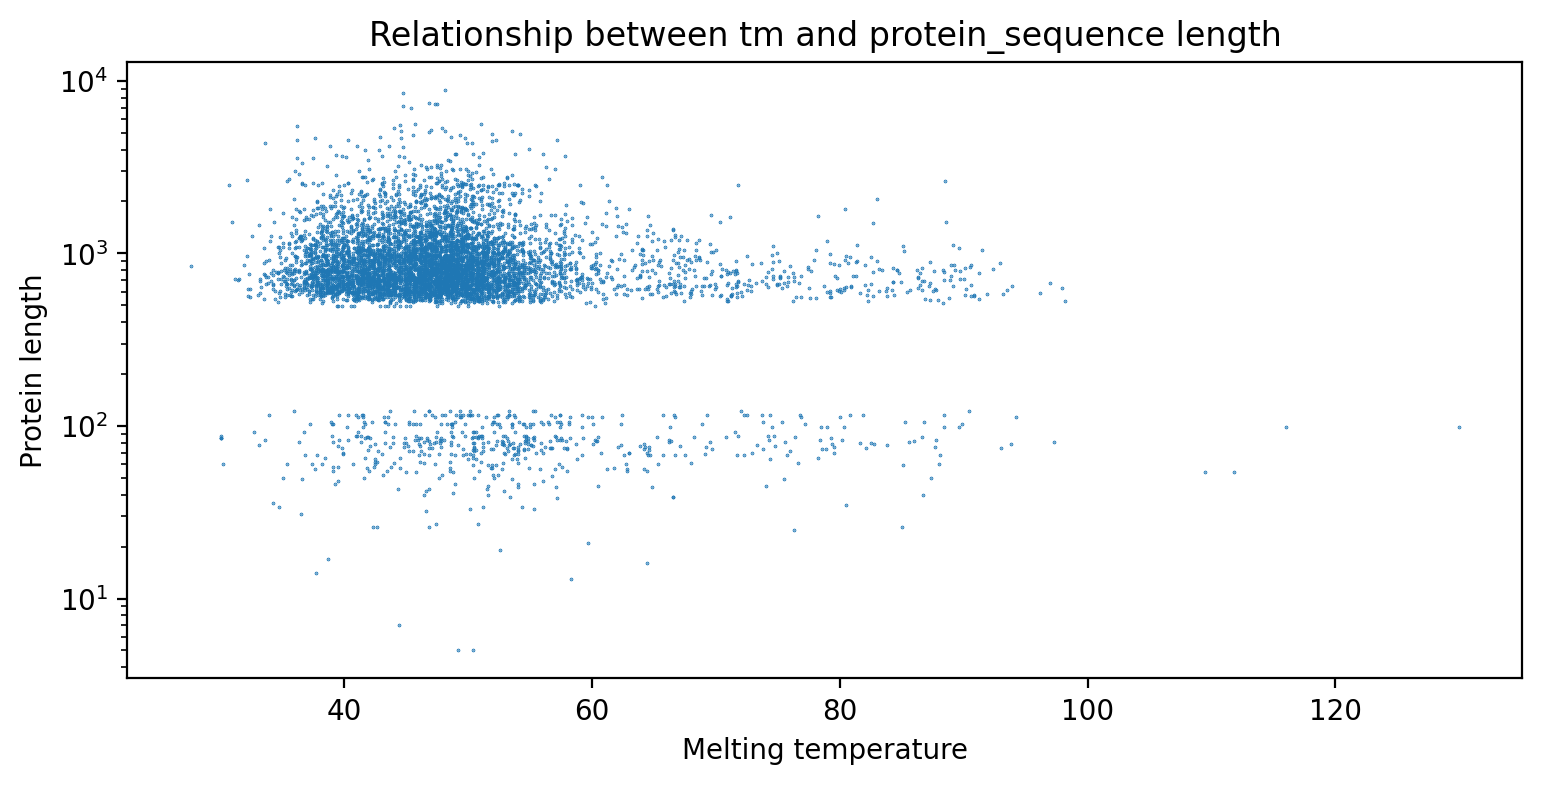

In [42]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(train["tm"], train["protein_sequence"].apply(lambda x:len(x)), s=0.1)
plt.title("Relationship between tm and protein_sequence length")
plt.ylabel("Protein length")
plt.xlabel("Melting temperature")
plt.yscale('log')
plt.show()

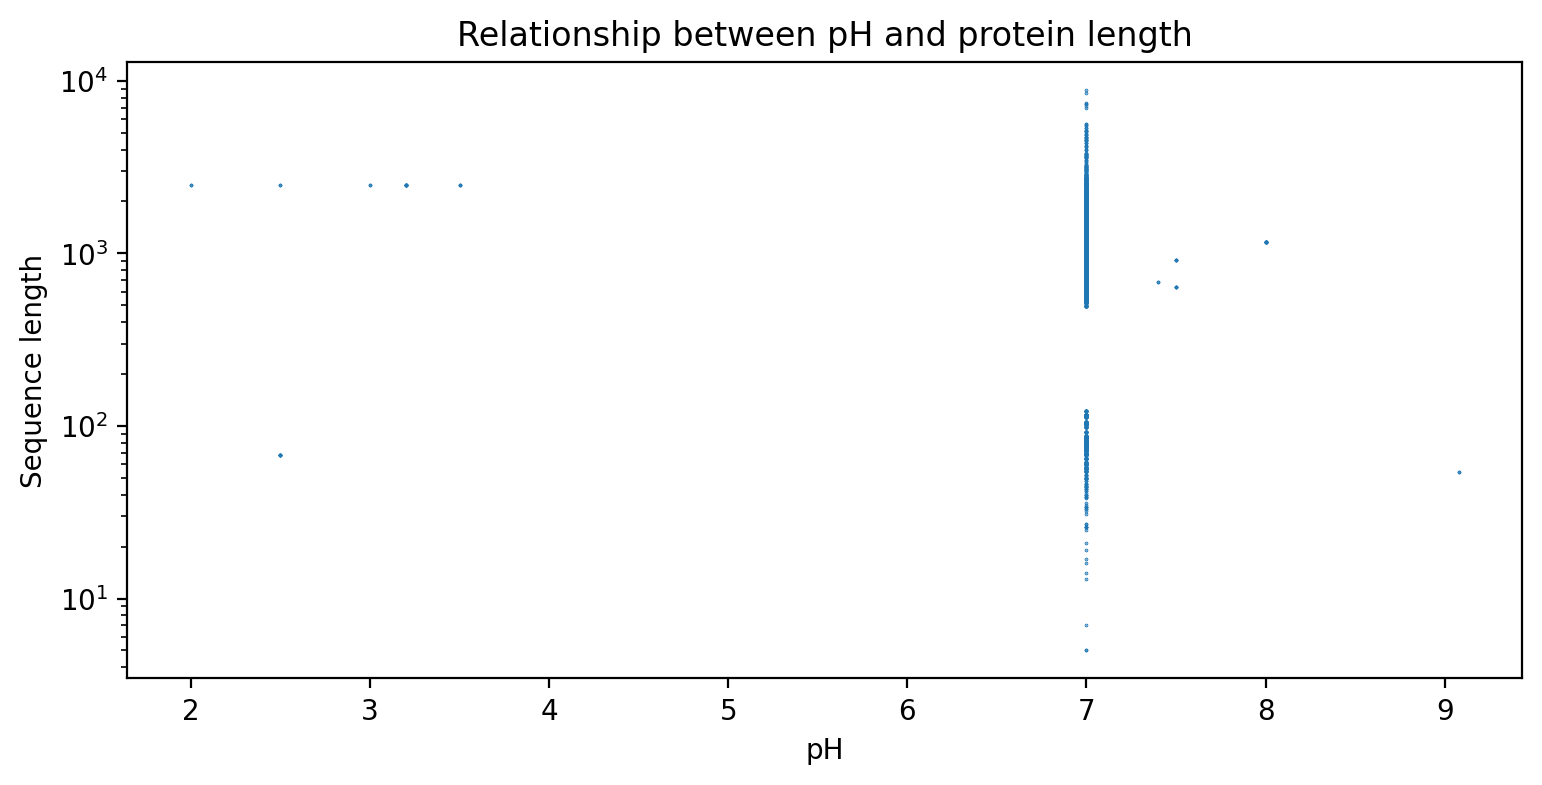

In [43]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(np.clip(train["pH"],0,14), train["protein_sequence"].apply(lambda x:len(x)), s=0.1)
plt.title("Relationship between pH and protein length")
plt.xlabel("pH")
plt.ylabel("Sequence length")
plt.yscale('log')
plt.show()

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
cat_cols = [col_name for col_name in X_train_x.columns if X_train_x[col_name].dtype == "object"]
cat_trans = Pipeline(steps=[
           ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_trans, cat_cols)])
regressor=GradientBoostingRegressor(
 max_depth=2,
 n_estimators=3,
 learning_rate=1)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', regressor)])
model_pipeline.fit(X_train_x,X_train_y)
y_pred=model_pipeline.predict(X_test_x)
print(y_pred)


#print(X_train_x)
#regressor.fit(X_train_x,X_train_y)

[47.0307454 48.8122604 48.8122604 ... 47.0307454 47.0307454 48.8122604]


           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_trans, cat_cols)])
regressor=GradientBoostingRegressor(
 max_depth=2,
 n_estimators=3,
 learning_rate=1)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', regressor)])
model_pipeline.fit(X_train_x,X_train_y)
y_pred=model_pipeline.predict(X_test_x)
print(y_pred)

score=mean_absolute_error(X_test_y,y_pred)
print(score)

#print(X_train_x)
#regressor.fit(X_train_x,X_train_y)

# Model 1: XGBoost

In [22]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import arange
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
cat_cols = [col_name for col_name in X_train_x.columns if X_train_x[col_name].dtype == "object"]
cat_trans = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_trans, cat_cols)])

In [ ]:
def ModelTraining(X_train_x, X_train_y, X_test_x, X_test_y, preprocessor):

    #Model definition
    # model = XGBRegressor(scale_pos_weight=1,
    #                      learning_rate=0.01,
    #                      colsample_bytree=0.4,
    #                      subsample=0.8,
    #                      objective='reg:squarederror',
    #                      eval_metric=mean_absolute_error,
    #                      n_estimators=1000,
    #                      reg_alpha=0.3,
    #                      max_depth=4,
    #                      gamma=10)

    model = XGBRegressor(subsample=0.6,
                         n_estimators=500,
                         max_depth=6,
                         learning_rate=0.01,
                         colsample_bytree=0.7999999999999999,
                         colsample_bylevel=0.5,
                         seed=20)
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Tuning
    # params = {'max_depth': [3, 6, 10],
    #           'learning_rate': [0.01, 0.05, 0.1],
    #           'n_estimators': [100, 500, 1000],
    #           'colsample_bytree': [0.3, 0.7]}

    params = {'max_depth': [3, 5, 6, 10, 15, 20],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': arange(0.5, 1.0, 0.1),
              'colsample_bytree': arange(0.4, 1.0, 0.1),
              'colsample_bylevel': arange(0.4, 1.0, 0.1),
              'n_estimators': [100, 500, 1000]}

    #Definition of model selection
    clf = RandomizedSearchCV(estimator=model,
                             param_distributions=params,
                             scoring='neg_mean_squared_error',
                             n_iter=25,
                             verbose=1)

    # # Preprocessing of training data, fit model
    model_pipeline.fit(X_train_x, X_train_y)
    
    clf_Pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # # Preprocessing of validation data, get predictions
    y_pred = model_pipeline.predict(X_test_x)

    # # Evaluate the model
    score = mean_absolute_error(X_test_y, y_pred)
    return [score, y_pred]
    

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
cat_cols = [col_name for col_name in X_train_x.columns if X_train_x[col_name].dtype == "object"]
cat_trans = Pipeline(steps=[
           ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_trans, cat_cols)])
regressor=GradientBoostingRegressor(
 max_depth=2,
 n_estimators=3,
 learning_rate=1)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', regressor)])
model_pipeline.fit(X_train_x,X_train_y)
y_pred=model_pipeline.predict(X_test_x)
print(y_pred)



#print(X_train_x)
#regressor.fit(X_train_x,X_train_y)

In [ ]:
print(ModelTraining(X_train_x, X_train_y, X_test_x, X_test_y, preprocessor)[0])

6.329314809971824


In [ ]:
print(pd.DataFrame(ModelTraining(X_train_x, X_train_y, X_test_x, X_test_y, preprocessor)[1]))

              0
0     47.154408
1     50.272427
2     50.272427
3     48.046021
4     50.272427
...         ...
1354  50.272427
1355  48.046021
1356  47.154408
1357  47.154408
1358  48.046021

[1359 rows x 1 columns]


In [ ]:
X_test_y

12       62.8
94       46.7
95       48.8
198      60.9
255      50.4
         ... 
31298    57.2
31325    58.2
31329    53.5
31350    42.5
31358    43.4
Name: tm, Length: 1359, dtype: float64